# OBJECTIVE:
TO DETECT WHETHER A PERSON HAS WORN A MASK OR NOT, WE WILL BE LEVERAGING THE POWER OF RESNET 50


# OUR DATASET CONSISTS OF THREE CLASS
1. INCORRECT MASK - THIS FOLDER CONSISTS OF IMAGES WHERE PEOPLE WEAR MASK INCORRECTLY EXAMPLE: LIKE A PERSON WEARING MASK WHERE HIS NOSE IS NOT FULLY COVERED OR THE MASK IS RESTING ON THE CHIN ETC

2. MASK - IN THIS FOLDER WE HAVE IMAGES WHERE A PERSON WEAR MASK PROPERLY

3. NO MASK - IN THIS FOLDER WE HAVE IMAGES WHERE A PERSON DOES NOT WEAR MASK

# DATASET:
YOU CAN DOWNLOAD THE DATASET FROM HERE: https://www.kaggle.com/spandanpatnaik09/face-mask-detectormask-not-mask-incorrect-mask

In [ ]:
# LOADING THE DEPENDENCIES WHICH WE WILL BE USING FURTHER FOR MODEL DETECTION

import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
from imutils import paths
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import os
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# path to input dataset
datapath = r'/content/drive/MyDrive/dataset (1)'

data = []
labels = []

imagePaths = list(paths.list_images(datapath))

for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = load_img(imagePath, target_size=(224,224))
    image = img_to_array(image)
    image = preprocess_input(image)
    data.append(image)
    labels.append(label)
print('Class Labels: ',np.unique(labels))
    
# Convert to Numpy array
data = np.array(data, dtype=np.float32)
labels = np.array(labels)

# one-hot the labels
lE = LabelEncoder()
labels = lE.fit_transform(labels)
labels = to_categorical(labels, num_classes=3)

print(data.shape)
print(labels.shape)
print('One hot encoded{}'.format(labels[0:3]))

Class Labels:  ['incorrect_mask' 'with_mask' 'without_mask']
(2079, 224, 224, 3)
(2079, 3)
One hot encoded[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [ ]:
# Split the data into 78% train and 22% test
train_data, test_data, train_labels, test_labels = train_test_split(data, labels,test_size=0.22, 
                                                                    random_state=42)

#construct the training image generator for data augmentation
datagen = ImageDataGenerator(rotation_range=20,
                            zoom_range=0.15,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.15,
                            horizontal_flip=True,
                            fill_mode='nearest')
datagen.fit(train_data)

print(train_data.shape, test_data.shape)

(1621, 224, 224, 3) (458, 224, 224, 3)


# Transfer Learning

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout


# Load the Resnet Network
resnet = ResNet50(weights = 'imagenet', # load the pre-trained weights on imagenet
                           include_top = True, # make sure the top layer is set to True
                           input_tensor = Input(shape=(224,224,3)))
# Construct the headModel that will be placed on top of the baseModel
headModel = resnet.layers[0].input
output = resnet.layers[-2].output
#headModel = Flatten(name='flatten')(headModel)
#headModel = Dense(80, activation='relu')(headModel)
#headModel = Dropout(0.5)(headModel)
predictions = Dense(3, activation='softmax')(output)

# Place the headModel on top of the baseModel (this becomes the actual model we will train)
model = Model(inputs = headModel, outputs = predictions)

# Loop over all  layers in the baseModel so that they will not be updated in the first training process
for layer in resnet.layers:
    layer.trainable = False

# Compile the Model

In [ ]:
print('Compiling the Model'+'...'*5)
BS = 32 # Batch size
INIT_lr = 1e-4 # learning rate
num_epoch = 10

# Adam optimizer
opt = tf.keras.optimizers.Adam(INIT_lr)
model.compile(loss='categorical_crossentropy', optimizer = opt, metrics=['accuracy'])

Compiling the Model...............


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

# Train the Model

In [ ]:
print('Training the Model'+'...'*5)

# train the model
History = model.fit(datagen.flow(train_data, train_labels, batch_size=BS),
                    steps_per_epoch=len(train_data) // BS, validation_steps=len(test_data) // BS,
                    validation_data=(test_data, test_labels),
                    epochs=num_epoch)

Training the Model...............
Epoch 1/10
50/50 [==============================] - 62s 586ms/step - loss: 0.9334 - accuracy: 0.5677 - val_loss: 0.6728 - val_accuracy: 0.7118
Epoch 2/10
50/50 [==============================] - 25s 497ms/step - loss: 0.5540 - accuracy: 0.7917 - val_loss: 0.4066 - val_accuracy: 0.8777
Epoch 3/10
50/50 [==============================] - 25s 495ms/step - loss: 0.3816 - accuracy: 0.8943 - val_loss: 0.2829 - val_accuracy: 0.9192
Epoch 4/10
50/50 [==============================] - 25s 490ms/step - loss: 0.2850 - accuracy: 0.9346 - val_loss: 0.2200 - val_accuracy: 0.9520
Epoch 5/10
50/50 [==============================] - 24s 487ms/step - loss: 0.2382 - accuracy: 0.9383 - val_loss: 0.1772 - val_accuracy: 0.9585
Epoch 6/10
50/50 [==============================] - 24s 480ms/step - loss: 0.1917 - accuracy: 0.9547 - val_loss: 0.1531 - val_accuracy: 0.9672
Epoch 7/10
50/50 [==============================] - 24s 482ms/step - loss: 0.1663 - accuracy: 0.9604 - val_l

# Evaluate the Model

### Making Predictions on the testing set

In [ ]:
from sklearn.metrics import classification_report
pred_idx = model.predict(test_data, BS)

# for each image on the testing set we need to find the index of the label with the corresponding 
# largest predicted probability
pred_idx = np.argmax(pred_idx, axis=1)
print(classification_report(test_labels.argmax(axis=1), pred_idx, target_names=lE.classes_))

                precision    recall  f1-score   support

incorrect_mask       0.96      0.99      0.97       154
     with_mask       0.99      0.96      0.98       163
  without_mask       0.99      1.00      1.00       141

      accuracy                           0.98       458
     macro avg       0.98      0.98      0.98       458
  weighted avg       0.98      0.98      0.98       458



In [ ]:
print(model.evaluate(test_data, test_labels, batch_size = 1))

458/458 [==============================] - 13s 25ms/step - loss: 0.0970 - accuracy: 0.9825
[0.09698629379272461, 0.9825327396392822]


# Plot of Training Loss/Accuracy

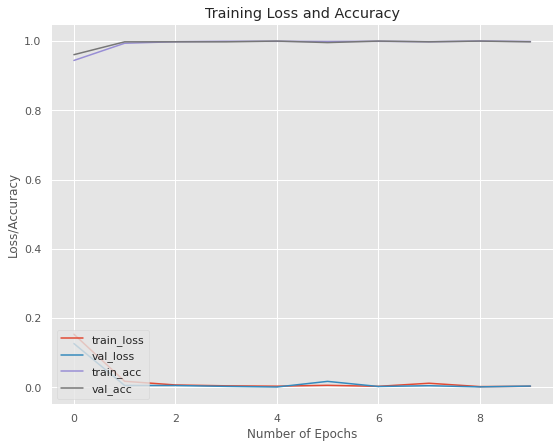

In [ ]:
N = num_epoch
plt.style.use('ggplot')
plt.figure(figsize=(9,7))
plt.plot(np.arange(0, N), History.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), History.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), History.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), History.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot for three classes")

In [ ]:
print(pred_idx[0:10])
print(test_labels[0:10])

[2 0 1 1 1 2 1 2 1 1]
[[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


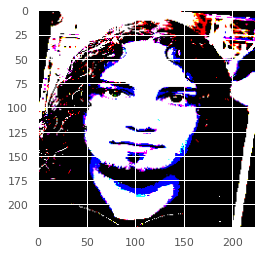

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


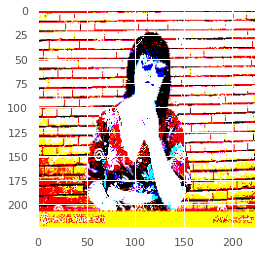

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


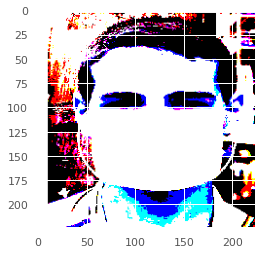

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


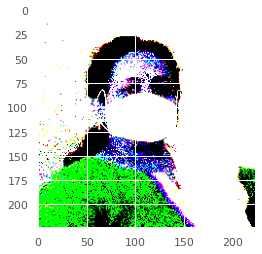

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


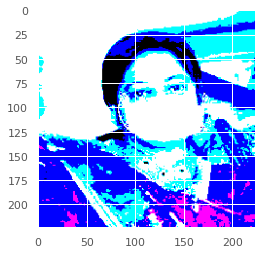

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


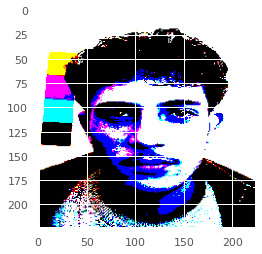

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


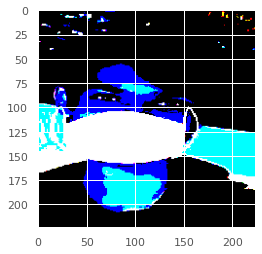

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


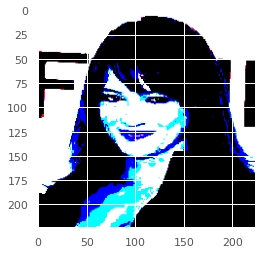

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


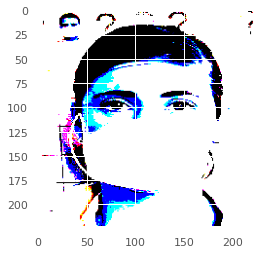

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


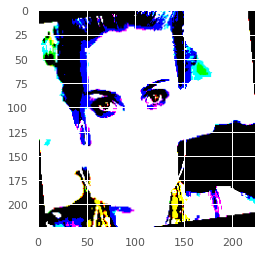

In [ ]:
#plotting the predicted values to check the prediction
for i in range(0,10):
  image = test_data[i]
  image = np.array(image,dtype = 'float')
  pixels = image.reshape((224,224,3))
  plt.imshow(pixels)
  plt.show()

In [ ]:
# SAVING OUR MODEL WHICH WE CAN FURTHER USE TO DETECT WHETHER A PERSON IS WEARING MASK OR NOT IN REALTIME USING OPENCV
model.save('face_mask_detector_Threeclasses (1).model', save_format='h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
